# References:

1. Most of the code snippets present here is taken from..
rosagradilla19/skincare-products-recommendation-system (2021). Available at: https://github.com/rosagradilla19/skincare-products-recommendation-system (Accessed: 2 May 2021).
 
2. Comparing cosmectics by ingredients (2021). Available at: https://www.datacamp.com/projects/695  (Accessed: 4 May 2021)

3. An Introduction to t-SNE with Python Example (2018). Available at: https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1 (Accessed: 2 May 2021).

4. sklearn.manifold.TSNE — scikit-learn 0.24.2 documentation (2021). Available at: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html (Accessed: 2 May 2021).


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE 
from scipy.spatial.distance import cdist

# Load the dataset from data folder
df = pd.read_csv("./data/cosmetics.csv")

# Checking  the first five rows of dataset
display(df.head())

# Inspecting  the types of products present in dataset
display(df['Label'].value_counts())

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


Moisturizer    298
Cleanser       281
Face Mask      266
Treatment      248
Eye cream      209
Sun protect    170
Name: Label, dtype: int64

In [3]:
#Shows number of rows and colums
df.shape

(1472, 11)

Focusing on one product category and one skin type.

Setting up worflow in such a way that the output obtained (a t-SNE model and a visualization of that model) can be customized. 


In [4]:
#Focusing on moisturizers for dry skin by filtering data accordingly.

#Filering for moisturizers
moisturizers = df[df['Label'] == 'Moisturizer']

# Filtering for Cleanser
cleansers = df[df['Label'] == 'Cleanser']

# Filtering for dry skin as well
moisturizers_subset = moisturizers[moisturizers['Oily'] == 1]

# Reseting index
moisturizers_subset = moisturizers_subset.reset_index(drop=True)

In [5]:
#Displaying five default rows.
cleansers.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
298,Cleanser,DRUNK ELEPHANT,T.L.C. Sukari Babyfacial™,80,4.5,"Water, Glycolic Acid, Hydroxyethyl Acrylate/So...",1,1,1,1,0
299,Cleanser,DRUNK ELEPHANT,T.L.C. Framboos™ Glycolic Night Serum,90,4.3,"Water, Glycolic Acid, Butylene Glycol, Glyceri...",1,1,1,1,0
300,Cleanser,FRESH,Soy Face Cleanser,38,4.4,"Water, Coco-Glucoside, Glycerin, Butylene Glyc...",0,0,0,0,0
301,Cleanser,FARMACY,Green Clean Makeup Meltaway Cleansing Balm wit...,34,4.6,"Cetyl Ethylhexanoate, Caprylic/Capric Triglyce...",1,1,1,1,1
302,Cleanser,PHILOSOPHY,Purity Made Simple Cleanser,24,4.5,"Water, Sodium Lauroamphoacetate, Sodium Tridec...",1,1,1,1,1


# Tokenizing ingredients:


For getting final result of comparing ingredients in each product, first  several preprocessing tasks should be completed and keeping track of the exact terms in each product's ingredients list should be done. Tokenizing the list of ingredients in the Ingredients column would be the first move. We'll make a binary bag of terms after breaking them into tokens. Then we'll make a dictionary out of the tokens.

In [6]:
# Initializing dictionary, list, and initial index
ingredient_idx = {}
corpus = []
idx = 0

# Using For loop for tokenization
for i in range(len(moisturizers_subset)):    
    ingredients = moisturizers_subset['Ingredients'][i]
    ingredients_lower = ingredients.lower()
    tokens = ingredients_lower.split(', ')
    corpus.append(tokens)
    for ingredient in tokens:
        if ingredient not in ingredient_idx:
            ingredient_idx[ingredient] = idx
            idx += 1
            
# Checking the result 
print("The index for decyl oleate is", ingredient_idx['decyl oleate'])

The index for decyl oleate is 25


# Creating a cosmetic ingredient matrix:


The next step is to build a document-term matrix (DTM). Each cosmetic product will be assigned a paper, and each chemical composition will be assigned a name. As a result, we should consider the matrix to be a “cosmetic-ingredient” matrix. To get started, we'll render an empty matrix loaded with zeros. The total number of cosmetic items in the data is represented by the length of the matrix.The total number of ingredients is represented by the matrix's distance. Following the initialization of this empty matrix, we can fill it in the following tasks.

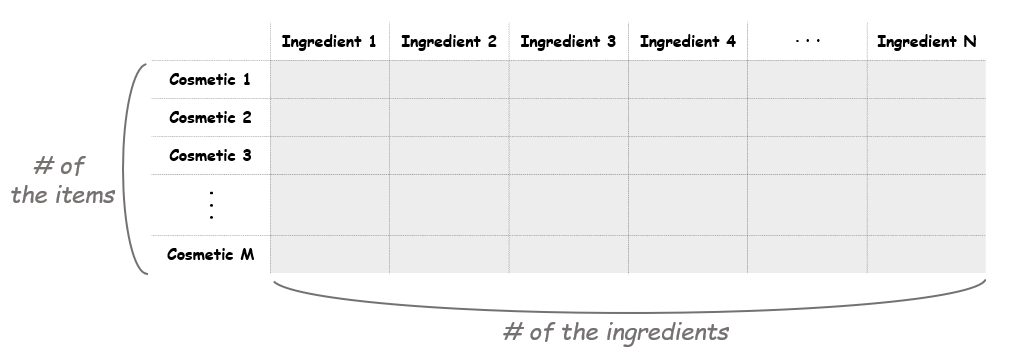

In [7]:
from IPython.display import Image
from PIL import Image


path="./data/image_1.jpg"
display(Image.open(path))

In [8]:
# Receiving the number of items and tokens 
M = len(moisturizers_subset)
N = len(ingredient_idx)

# Initializing a matrix of zeros
A = np.zeros((M,N))

In [9]:
#Shape of the matxix
A.shape

(179, 2149)

# Creating a counter function first:

Before starting to fill the matrix, writing a function that counts the tokens (i.e., an ingredients list) for each row helps. Our ultimate target is to fill the matrix with either 1 or 0: if an element is used in a cosmetic, the value is 1. If it does not, it is 0. The name of this feature, oh_encoder, will be revealed later.

In [10]:
# Defining the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)
    for ingredient in tokens:
        # Geting the index for each ingredient
        idx = ingredient_idx[ingredient]
        # Putting 1 at the corresponding indices
        x[idx] = 1
    return x

# Creating cosmetic ingredient matrix


Now using the oh_encoder() function on the tokens in corpus to set the values in each row of this matrix. As a consequence, the outcome will tell us what ingredients each object is made of. For instance, if a cosmetic object contains water, niacin, decyl aleate, and sh-polypeptide-1, the result would be as follows.


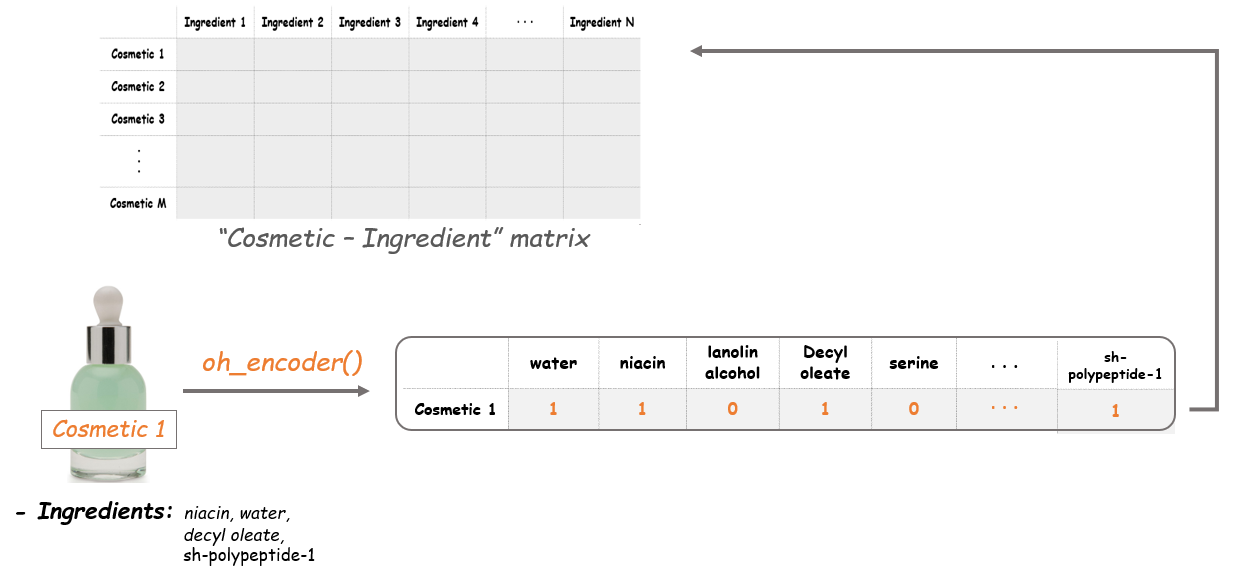

In [11]:
path="./data/image_2.jpg"
display(Image.open(path))

This called one-hot encoding. By encoding each ingredient in the items, the Cosmetic-Ingredient matrix will be filled with binary values

In [12]:
# Making a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i +=1

In [13]:
#Shape of matrix
A.shape

(179, 2149)

In [14]:
#Matrix design
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

# Dimension reduction with t-SNE

The current matrix has dimensions of (179, 2149), indicating that there are 2149 features in our results. We should reduce this to two dimensions for visualization purposes. In this case, we'll use t-SNE to reduce the dimension of the data.


T-distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear dimensionality reduction technique that is well-suited for embedding high-dimensional data for visualization in a two or three-dimensional low-dimensional space. This method, in particular, will minimize the dimension of data while preserving the similarity between instances. This allows one to plot the coordinate strategy. (Violante, 2018)

This allows one to render a plot on the coordinate plane, a process known as vectorizing. Many of the cosmetic products in our data will be vectorized into two-dimensional coordinates, with the distances between the points indicating the items' similarities.








In [59]:
# Dimension reduction with t-SNE
model = TSNE(n_components = 2, learning_rate = 200, random_state = 42) 
tsne_features = model.fit_transform(A)

# Making X, Y columns 
moisturizers_subset['X'] = tsne_features[:, 0]
moisturizers_subset['Y'] = tsne_features[:, 1]



n_components: Dimension of the embedded space.


random_state=42 because to produce same results across the run, it helps in ensuring that the splits that you generate are reproducible.

learning_rate:
The learning rate for t-SNE is usually in the [10.0, 1000.0] range. If the learning rate is too fast, the data can take the shape of a 'ball,' with any point roughly equidistant from its nearest neighbors. If the learning rate is too poor, the majority of the points can appear compressed in a dense cloud with few outliers. Increasing the learning rate can help if the cost feature becomes stuck in a bad local minimum.


(sklearn.manifold.TSNE)




In [60]:
#Showing first five rows of mosturizers subset
moisturizers_subset.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1,-126.549393,41.575001,[[1.1127808266836892]]
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1,34.083179,40.753788,[[4.933741258364805]]
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0,74.731613,158.359558,[[4.985281526141931]]
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1,107.959167,-97.470360,[[0.0]]
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1,9.706045,-166.296310,[[6.797810762117909]]


# Finding similar products.

In [61]:
target = moisturizers_subset[moisturizers_subset['Name'] == 'The Moisturizing Soft Cream']
target

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1,107.959167,-97.47036,[[0.0]]


In [62]:
#Coordinates of the targeted product
x  = target['X'].values[0]
y = target['Y'].values[0]
print(x, y)

107.95917 -97.47036


In [63]:
#coordinates of first five moisturizers_subset
df1 = pd.DataFrame()
df1['point'] = [(x, y) for x,y in zip(moisturizers_subset['X'], moisturizers_subset['Y'])]

df1.head()

,point
0,"(-126.54939270019531, 41.57500076293945)"
1,"(34.08317947387695, 40.753787994384766)"
2,"(74.73161315917969, 158.35955810546875)"
3,"(107.95916748046875, -97.4703598022461)"
4,"(9.706045150756836, -166.2963104248047)"


In [65]:
point = np.array([[x,y]])

point.shape

(1, 2)

In [66]:
cdist(point, np.array([[-9.456123352050781, 16.348276138305664]]), metric='euclidean')

array([[163.52685531]])

In [67]:

moisturizers_subset['distance'] = [cdist(np.array([[x,y]]), np.array([product]), metric='euclidean') for product in df1['point']]

In [68]:
moisturizers_subset.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1,-126.549393,41.575001,[[272.63139418033023]]
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1,34.083179,40.753788,[[156.72771496469585]]
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0,74.731613,158.359558,[[257.9787147476364]]
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1,107.959167,-97.470360,[[0.0]]
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1,9.706045,-166.296310,[[119.96119175231716]]


In [69]:
# arranging by descending order
top_matches = moisturizers_subset.sort_values(by=['distance'])
top_matches.head(5)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1,107.959167,-97.470360,[[0.0]]
175,Moisturizer,LA MER,The Moisturizing Matte Lotion,270,3.9,"Water, Algae (Seaweed) Extract, Propanediol, S...",0,0,1,1,0,107.332497,-116.863220,[[19.40298305212237]]
64,Moisturizer,PHILOSOPHY,Renewed Hope in A Jar Refreshing & Refining Mo...,39,4.1,"Water, Cyclopentasiloxane, Stearic Acid, Glyce...",1,1,1,1,1,84.636925,-81.640900,[[28.186855353636567]]
13,Moisturizer,DRUNK ELEPHANT,The Littles™,90,4.4,"Beste™ No.9 Jelly Cleanser: Water, Sodium Laur...",1,1,1,1,0,123.045326,-68.003548,[[33.104156887495]]
85,Moisturizer,MURAD,Retinol Youth Renewal Night Cream,82,4.6,"Water, Dimethicone, Glycerin, Butyrospermum Pa...",1,1,1,1,1,140.625366,-103.466461,[[33.211952234857485]]


In [70]:
top_matches = top_matches[['Label', 'Brand', 'Name', 'Price', 'Ingredients', 'distance']]
top_matches = top_matches.reset_index()
top_matches = top_matches.drop(top_matches.index[0])
top_matches.head()

,index,Label,Brand,Name,Price,Ingredients,distance
1,175,Moisturizer,LA MER,The Moisturizing Matte Lotion,270,"Water, Algae (Seaweed) Extract, Propanediol, S...",[[19.40298305212237]]
2,64,Moisturizer,PHILOSOPHY,Renewed Hope in A Jar Refreshing & Refining Mo...,39,"Water, Cyclopentasiloxane, Stearic Acid, Glyce...",[[28.186855353636567]]
3,13,Moisturizer,DRUNK ELEPHANT,The Littles™,90,"Beste™ No.9 Jelly Cleanser: Water, Sodium Laur...",[[33.104156887495]]
4,85,Moisturizer,MURAD,Retinol Youth Renewal Night Cream,82,"Water, Dimethicone, Glycerin, Butyrospermum Pa...",[[33.211952234857485]]
5,6,Moisturizer,DRUNK ELEPHANT,Lala Retro™ Whipped Cream,60,"Water, Glycerin, Caprylic/ Capric Triglyceride...",[[33.51466059447983]]


In [71]:
cosmetic_1 = moisturizers_subset[moisturizers_subset['Name'] == "The Moisturizing Soft Cream"]
cosmetic_2 = moisturizers_subset[moisturizers_subset['Name'] == "Moisture Surge Hydrating Supercharged Concentrate"]

In [72]:
# Displaying each item's data and ingredients
display(cosmetic_1)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Ingredients.values)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1,107.959167,-97.47036,[[0.0]]


['Algae (Seaweed) Extract, Cyclopentasiloxane, Petrolatum, Glyceryl Distearate, Phenyl Trimethicone, Butylene Glycol, Hydrogenated Vegetable Oil, Cholesterol, Butyrospermum Parkii (Shea Butter), Steareth-10, Dimethicone, Glyceryl Stearate Se, Polysilicone-11, Sesamum Indicum (Sesame) Seed Oil, Medicago Sativa (Alfalfa) Seed Powder, Helianthus Annuus (Sunflower) Seedcake, Prunus Amygdalus Dulcis (Sweet Almond) Seed Meal, Eucalyptus Globulus (Eucalyptus) Leaf Oil, Sodium Gluconate, Copper Gluconate, Calcium Gluconate, Magnesium Gluconate, Zinc Gluconate, Tocopheryl Succinate, Niacin, Sesamum Indicum (Sesame) Seed Powder, Water, Citrus Aurantifolia (Lime) Peel Extract, Laminaria Digitata Extract, Crithmum Maritimum Extract, Salicornia Herbacea Extract, Plankton Extract, Chlorella Vulgaris Extract, Glycine Soja (Soybean) Seed Extract, Glycerin, Caffeine, Sea Salt/Maris Sal/Sel Marin, Micrococcus Lysate, Diethylhexyl Succinate, Adenosine Phosphate, Creatine, Hydrolyzed Algin, Isocetyl Stear

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
130,Moisturizer,CLINIQUE,Moisture Surge Hydrating Supercharged Concentrate,39,4.0,"Water , Glycerin , Butylene Glycol , Phenyl Tr...",1,1,1,1,1,-141.376709,63.835728,[[296.9647001835074]]


['Water , Glycerin , Butylene Glycol , Phenyl Trimethicone , Propanediol , Sucrose , Hydroxyethyl Urea , Alteromonas Ferment Extract , Hydrolyzed Rice Extract , Acetyl Glucosamine , Trehalose , Algae Extract , Caffeine , Cholesterol , Aloe Barbadensis Leaf Water , Sodium Hyaluronate , Pentaerythrityl Tetraethylhexanoate , Dextrin Palmitate , Acrylates/C10-30 Alkyl Acrylate Crosspolymer , Sorbitol , Sodium Polyaspartate , Tocopheryl Acetate , Carbomer , Dehydroxanthan Gum , Citric Acid , Tetrahexyldecyl Ascorbate , Benzophenone-4 , Pentaerythrityl Tetra-Di-T-Butyl Hydroxyhydrocinnamate , Sodium Hydroxide , Sodium Citrate , Disodium Edta , Bht , Chlorphenesin , Phenoxyethanol , Red 4 (Ci 14700) , Yellow 5 (Ci 19140)']


In [73]:
c1 = cosmetic_1.Ingredients.values
c2 = cosmetic_2.Ingredients.values

In [74]:
# making list of ingredients
c1_list = c1[0].split(",")
c2_list = c2[0].split(",")

# striping spaces
c1_list = [x.strip(' ') for x in c1_list]
c2_list = [x.strip(' ') for x in c2_list]

In [75]:
# turning lists into sets for comparison
c1_set = set(c1_list)
c2_set = set(c2_list)

In [76]:
# getting same ingredients
same_ingredients = c2_set.intersection(c1_set)
print(same_ingredients)

{'Tetrahexyldecyl Ascorbate', 'Glycerin', 'Sodium Hyaluronate', 'Phenyl Trimethicone', 'Water', 'Cholesterol', 'Tocopheryl Acetate', 'Caffeine', 'Bht', 'Phenoxyethanol', 'Sucrose', 'Butylene Glycol', 'Trehalose', 'Disodium Edta'}


In [77]:
#showing the same ingredients by comparing the two sets from the list ingredients value
top_matches['Ingredients in common'] = [c1_set.intersection( set([x.strip(' ')for x in product.split(",")]) ) for product in top_matches['Ingredients']]
top_matches.head(5)

,index,Label,Brand,Name,Price,Ingredients,distance,Ingredients in common
1,175,Moisturizer,LA MER,The Moisturizing Matte Lotion,270,"Water, Algae (Seaweed) Extract, Propanediol, S...",[[19.40298305212237]],"{Tetrahexyldecyl Ascorbate, Crithmum Maritimum..."
2,64,Moisturizer,PHILOSOPHY,Renewed Hope in A Jar Refreshing & Refining Mo...,39,"Water, Cyclopentasiloxane, Stearic Acid, Glyce...",[[28.186855353636567]],"{Laureth-7, Polyacrylamide, Glycerin, Sodium H..."
3,13,Moisturizer,DRUNK ELEPHANT,The Littles™,90,"Beste™ No.9 Jelly Cleanser: Water, Sodium Laur...",[[33.104156887495]],"{Tetrahexyldecyl Ascorbate, Potassium Sorbate,..."
4,85,Moisturizer,MURAD,Retinol Youth Renewal Night Cream,82,"Water, Dimethicone, Glycerin, Butyrospermum Pa...",[[33.211952234857485]],"{Zinc Gluconate, Glycerin, Urea, Caprylic/Capr..."
5,6,Moisturizer,DRUNK ELEPHANT,Lala Retro™ Whipped Cream,60,"Water, Glycerin, Caprylic/ Capric Triglyceride...",[[33.51466059447983]],"{Glycerin, Water, Pentylene Glycol, Phenoxyeth..."


# Mapping the items with bokeh

Starting to create the plot on coordinate plane. With the t-SNE values obtained, we can plot all items on the coordinate plane. And  it will also show us the name, the brand, the price and the rank of each item. Now making a scatter plot using Bokeh and add a hover tool to show that information.  The plot wont be displayed yet as some more additions are yet to be made to it.

In [78]:
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

# Making a source and a scatter plot  
source = ColumnDataSource(moisturizers_subset)
plot = figure(x_axis_label = 'T-SNE 1', 
              y_axis_label = 'T-SNE 2', 
              width = 500, height = 400)
plot.circle(x = 'X', 
    y = 'Y', 
    source = source, 
    size = 10, color = '#FF7373', alpha = .8)

Loading BokehJS ...

GlyphRenderer(id='1265', ...)

# Adding hover tool

Adding a hover tool allows us to check the information of each item whenever the cursor is directly over a character. We will add tooltips with each product's name, brand, price, and rank (i.e., rating).

In [79]:
# Creating  a HoverTool object
hover = HoverTool(tooltips = [('Item', '@Name'),
                              ('Brand', '@Brand'),
                              ('Price', '$@Price'),
                              ('Rank', '@Rank')])
plot.add_tools(hover)

# Mapping items

Each point on the plot corresponds to the cosmetic items. 

The axes of a t-SNE plot aren't easily interpretable in terms of the original data. Like mentioned above, t-SNE is a visualizing technique to plot high-dimensional data in a low-dimensional space.

As a result, quantitative interpretation of an t-SNE plot is not recommended. Instead, we can deduce the distance between the points from this map (which items are close and which are far apart). The closer the distance between the two items is, the more similar the composition they have. Therefore this enables us to compare the items without having any chemistry background.ry.


In [80]:
# Plot the map
show(plot)

# Comparing two products

Since there are so many cosmetics and ingredients, the plot lacks the clear trends that simpler t-SNE plots should provide. 

For example: 
If we liked one product, there's a good chance we'd like another one with a similar chemical structure. Let's pretend we liked AmorePacific's Color Control Cushion Compact Broad Spectrum SPF 50+. We should locate this product on the plot to see if there are any related products. It turns out that it is! 
When we look at the plot's far leftmost points, we can see that LANEIGE's BB Cushion Hydra Radiance SPF 50 essentially overlaps with the AmorePacific product. We can physically check the formulations of the materials are identical by looking at the ingredients (though this is difficult to do, which is why we did this research in the first place! ), plus LANEIGE's variant is $22 cheaper and actually has high quality ingredients.

It's not flawless, but it's functional. In practice, we will use our little ingredient-based advice engine to help us make informed cosmetic purchases.



In [81]:
# Print the ingredients of two similar cosmetics
cosmetic_1 = moisturizers_subset[moisturizers_subset['Name'] == "Color Control Cushion Compact Broad Spectrum SPF 50+"]
cosmetic_2 = moisturizers_subset[moisturizers_subset['Name'] == "BB Cushion Hydra Radiance SPF 50"]

# Display each item's data and ingredients
display(cosmetic_1)
print(cosmetic_1.Ingredients.values)
display(cosmetic_2)
print(cosmetic_2.Ingredients.values)

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
40,Moisturizer,AMOREPACIFIC,Color Control Cushion Compact Broad Spectrum S...,60,4.0,"Phyllostachis Bambusoides Juice, Cyclopentasil...",1,1,1,1,1,-74.530495,96.883644,[[266.6007419972065]]


['Phyllostachis Bambusoides Juice, Cyclopentasiloxane, Cyclohexasiloxane, Peg-10 Dimethicone, Phenyl Trimethicone, Butylene Glycol, Butylene Glycol Dicaprylate/Dicaprate, Alcohol, Arbutin, Lauryl Peg-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Polyhydroxystearic Acid, Sodium Chloride, Polymethyl Methacrylate, Aluminium Hydroxide, Stearic Acid, Disteardimonium Hectorite, Triethoxycaprylylsilane, Ethylhexyl Palmitate, Lecithin, Isostearic Acid, Isopropyl Palmitate, Phenoxyethanol, Polyglyceryl-3 Polyricinoleate, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Disodium Edta, Trimethylsiloxysilicate, Ethylhexyglycerin, Dimethicone/Vinyl Dimethicone Crosspolymer, Water, Silica, Camellia Japonica Seed Oil, Camillia Sinensis Leaf Extract, Caprylyl Glycol, 1,2-Hexanediol, Fragrance, Titanium Dioxide, Iron Oxides (Ci 77492, Ci 77491, Ci77499).']


,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive,X,Y,distance
49,Moisturizer,LANEIGE,BB Cushion Hydra Radiance SPF 50,38,4.3,"Water, Cyclopentasiloxane, Zinc Oxide (CI 7794...",1,1,1,1,1,-70.285721,109.610764,[[273.22853411722195]]


['Water, Cyclopentasiloxane, Zinc Oxide (CI 77947), Ethylhexyl Methoxycinnamate, PEG-10 Dimethicone, Cyclohexasiloxane, Phenyl Trimethicone, Iron Oxides (CI 77492), Butylene Glycol Dicaprylate/Dicaprate, Niacinamide, Lauryl PEG-9 Polydimethylsiloxyethyl Dimethicone, Acrylates/Ethylhexyl Acrylate/Dimethicone Methacrylate Copolymer, Titanium Dioxide (CI 77891 , Iron Oxides (CI 77491), Butylene Glycol, Sodium Chloride, Iron Oxides (CI 77499), Aluminum Hydroxide, HDI/Trimethylol Hexyllactone Crosspolymer, Stearic Acid, Methyl Methacrylate Crosspolymer, Triethoxycaprylylsilane, Phenoxyethanol, Fragrance, Disteardimonium Hectorite, Caprylyl Glycol, Yeast Extract, Acrylates/Stearyl Acrylate/Dimethicone Methacrylate Copolymer, Dimethicone, Trimethylsiloxysilicate, Polysorbate 80, Disodium EDTA, Hydrogenated Lecithin, Dimethicone/Vinyl Dimethicone Crosspolymer, Mica (CI 77019), Silica, 1,2-Hexanediol, Polypropylsilsesquioxane, Chenopodium Quinoa Seed Extract, Magnesium Sulfate, Calcium Chloride